In [12]:
import nltk
nltk.download("popular")
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import string
from nltk.corpus import stopwords
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import statsmodels.api as sm
from scipy import stats

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [2]:
df= pd.read_csv('/content/drive/MyDrive/Plagiarism Detector /train_snli.txt', sep='\t')
df.head()


,A person on a horse jumps over a broken down airplane.,"A person is at a diner, ordering an omelette.",0
0,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
1,Children smiling and waving at camera,There are children present,1
2,Children smiling and waving at camera,The kids are frowning,0
3,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0
4,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.,1


In [3]:
df.shape

(367372, 3)

In [4]:
new_df = df.rename(columns={'A person on a horse jumps over a broken down airplane.': 'source_text',
                            'A person is at a diner, ordering an omelette.': 'plagiarized_text',
                            '0': 'label'},inplace=True)

In [7]:
df.head(30)

,source_text,plagiarized_text,label
0,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
1,Children smiling and waving at camera,There are children present,1
2,Children smiling and waving at camera,The kids are frowning,0
3,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0
4,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.,1
5,An older man sits with his orange juice at a s...,A boy flips a burger.,0
6,Two blond women are hugging one another.,The women are sleeping.,0
7,Two blond women are hugging one another.,There are women showing affection.,1
8,"A few people in a restaurant setting, one of t...",The people are sitting at desks in school.,0
9,"A few people in a restaurant setting, one of t...",The diners are at a restaurant.,1


In [6]:
df['label'].value_counts()

,count
label,
0,183965
1,183407


In [9]:
# 1. Null value check
print("Null Values in Each Column:\n", df.isnull().sum(), "\n")

# 2. Duplicate row check
print("Total Duplicate Rows:", df.duplicated().sum(), "\n")

Null Values in Each Column:
 source_text         0
plagiarized_text    4
label               0
dtype: int64 

Total Duplicate Rows: 454 



In [22]:
# Problem 1:
# Is there a significant difference between the lengths
# of source and plagiarized texts?
# Import libraries
import pandas as pd
import numpy as np
from scipy.stats import t, norm, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Add length columns
df['source_length'] = df['source_text'].apply(len)
df['plagiarized_length'] = df['plagiarized_text'].apply(len)

# Function to calculate confidence interval
def get_conf_interval(data, conf=0.95):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = std / np.sqrt(n)
    return t.interval(conf, df=n-1, loc=mean, scale=se)

# Confidence Intervals for both
ci_source = get_conf_interval(df['source_length'])
ci_plag = get_conf_interval(df['plagiarized_length'])

print("95% Confidence Interval for Source Text Length:", ci_source)
print("95% Confidence Interval for Plagiarized Text Length:", ci_plag)


# -------------------------------------------------------
# Hypothesis Testing (Independent T-test)
# H0: Mean source length == Mean plagiarized length
# H1: They are different
# -------------------------------------------------------
t_stat, p_val = ttest_ind(df['source_length'], df['plagiarized_length'], equal_var=False)
print("\n🔬 T-Test: Is there a significant difference in text lengths?")
print("T-statistic:", t_stat)
print("P-value:", p_val)

if p_val < 0.05:
    print("Significant difference. Reject null hypothesis.")
else:
    print("No significant difference. Fail to reject null hypothesis.")


95% Confidence Interval for Source Text Length: (np.float64(47.274688547188184), np.float64(47.41070936011014))
95% Confidence Interval for Plagiarized Text Length: (np.float64(23.75105812038406), np.float64(23.81984548685874))

🔬 T-Test: Is there a significant difference in text lengths?
T-statistic: 605.8261478014603
P-value: 0.0
Significant difference. Reject null hypothesis.


In [23]:
def preprocess_text(text):
    # Ensure the input is a string
    text = str(text)
    # Removes punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Converts to lowercase
    text = text.lower()
    # Remove stop words(like a, over, etc)
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# Applying preprocessing to both columns
df["source_text"] = df["source_text"].astype(str).apply(preprocess_text)
df["plagiarized_text"] = df["plagiarized_text"].astype(str).apply(preprocess_text)

In [ ]:
df.head()

,source_text,plagiarized_text,label
0,person horse jumps broken airplane,person outdoors horse,1
1,children smiling waving camera,children present,1
2,children smiling waving camera,kids frowning,0
3,boy jumping skateboard middle red bridge,boy skates sidewalk,0
4,boy jumping skateboard middle red bridge,boy skateboarding trick,1


# Vectorization of string

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df["source_text"] + " " + df["plagiarized_text"])

In [ ]:
y = df["label"]

#Splitting the data into training and testing

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Proportions of data:
# Train: 60%
# Val:   20%
# Test:  20%

#Model 1 - Logistic Regression


=== Validation Evaluation ===
Validation Accuracy: 0.6849948962232052
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67     36729
           1       0.67      0.72      0.70     36746

    accuracy                           0.68     73475
   macro avg       0.69      0.68      0.68     73475
weighted avg       0.69      0.68      0.68     73475

Validation Confusion Matrix:
[[23821 12908]
 [10237 26509]]


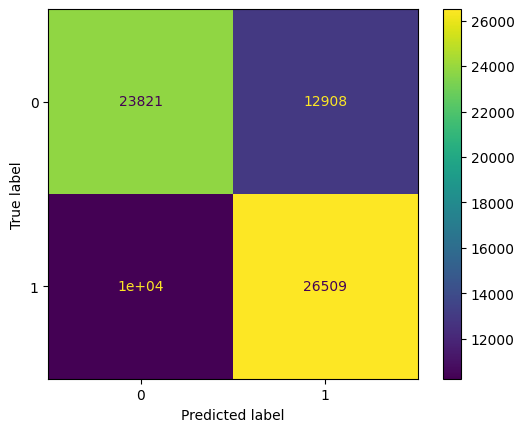

In [ ]:
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

val_pred = logistic_model.predict(X_val)

#Evaluating on validation set
val_accuracy = accuracy_score(y_val, val_pred)
val_classification_report = classification_report(y_val, val_pred)
val_confusion_matrix = confusion_matrix(y_val, val_pred)

print("=== Validation Evaluation ===")
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:")
print(val_classification_report)
print("Validation Confusion Matrix:")
print(val_confusion_matrix)

# # Evaluate on the test set
# test_pred = model.predict(X_test)
# test_accuracy = accuracy_score(y_test, test_pred)
# test_classification_report = classification_report(y_test, test_pred)
# test_confusion_matrix = confusion_matrix(y_test, test_pred)

# print("\n=== Final Test Evaluation ===")
# print("Test Accuracy:", test_accuracy)
# print("Test Classification Report:")
# print(test_classification_report)
# print("Test Confusion Matrix:")
# print(test_confusion_matrix)

# Display the confusion matrix for the validation set
cm_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_matrix, display_labels=logistic_model.classes_)
cm_display.plot()

#Model 2 - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Validation Accuracy: 0.6640353861857775


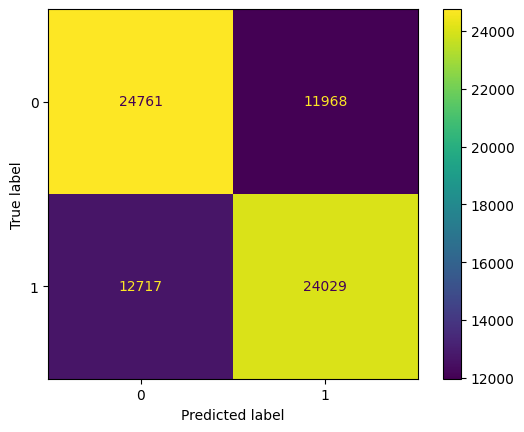

In [ ]:
#I am commenting out random forest model as i reduced the feautres for this as it was taking long time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Use reduced feature TF-IDF if not already
# tfidf_vectorizer = TfidfVectorizer(max_features=10000)
# X = tfidf_vectorizer.fit_transform(df["source_text"] + " " + df["plagiarized_text"])
# y = df["label"]

# random_forest_model = RandomForestClassifier(n_estimators=10, random_state=42)
# random_forest_model.fit(X_train, y_train)

# Validation
# val_pred = random_forest_model.predict(X_val)
# val_accuracy = accuracy_score(y_val, val_pred)
# print("Validation Accuracy:", val_accuracy)

# # Confusion Matrix
# val_cm = confusion_matrix(y_val, val_pred)
# cm_display = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=random_forest_model.classes_)
# cm_display.plot()


In [ ]:
# # --- Final Evaluation on Test Set ---
# test_pred = random_forest_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, test_pred)
# test_report = classification_report(y_test, test_pred)
# test_cm = confusion_matrix(y_test, test_pred)

# print("\n=== Test Set Evaluation ===")
# print("Test Accuracy:", test_accuracy)
# print("Classification Report:\n", test_report)
# print("Confusion Matrix:\n", test_cm)

#Model 3 - Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:

naive_bayes_model = MultinomialNB()

naive_bayes_model.fit(X_train, y_train)

#Evaluate on Validation Set
val_pred = naive_bayes_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
val_report = classification_report(y_val, val_pred)
val_cm = confusion_matrix(y_val, val_pred)

print("\n=== Validation Set Evaluation ===")
print("Validation Accuracy:", val_accuracy)
print("Classification Report:\n", val_report)
print("Confusion Matrix:\n", val_cm)


=== Validation Set Evaluation ===
Validation Accuracy: 0.6446002041510718
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.59      0.62     36729
           1       0.63      0.70      0.66     36746

    accuracy                           0.64     73475
   macro avg       0.65      0.64      0.64     73475
weighted avg       0.65      0.64      0.64     73475

Confusion Matrix:
 [[21609 15120]
 [10993 25753]]


In [ ]:
# test_pred = naive_bayes_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, test_pred)
# test_report = classification_report(y_test, test_pred)
# test_cm = confusion_matrix(y_test, test_pred)

# print("\n=== Test Set Evaluation ===")
# print("Test Accuracy:", test_accuracy)
# print("Classification Report:\n", test_report)
# print("Confusion Matrix:\n", test_cm)

#Model 4 - XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Validation Set Evaluation ===
Validation Accuracy: 0.7384280367471929
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.72     36729
           1       0.71      0.82      0.76     36746

    accuracy                           0.74     73475
   macro avg       0.74      0.74      0.74     73475
weighted avg       0.74      0.74      0.74     73475

Confusion Matrix:
 [[24280 12449]
 [ 6770 29976]]


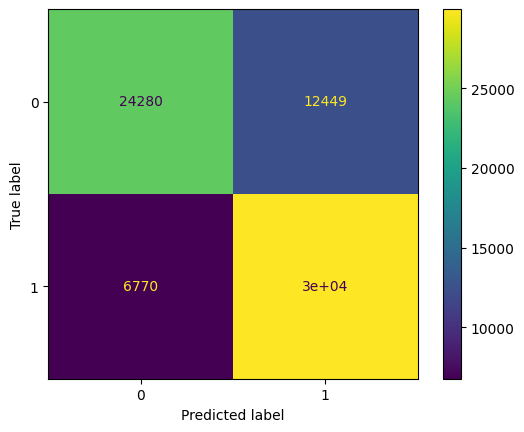

In [ ]:
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, random_state=42)

# xgboost_model.fit(X_train, y_train)


val_pred = xgboost_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
val_report = classification_report(y_val, val_pred)
val_cm = confusion_matrix(y_val, val_pred)

print("\n=== Validation Set Evaluation ===")
print("Validation Accuracy:", val_accuracy)
print("Classification Report:\n", val_report)
print("Confusion Matrix:\n", val_cm)

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=xgboost_model.classes_).plot()


In [ ]:
# test_pred = xgboost_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, test_pred)
# test_report = classification_report(y_test, test_pred)
# test_cm = confusion_matrix(y_test, test_pred)

# print("\n=== Test Set Evaluation ===")
# print("Test Accuracy:", test_accuracy)
# print("Classification Report:\n", test_report)
# print("Confusion Matrix:\n", test_cm)

#Model 5 - SVM(Support Vector machine)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)
# svm_model.fit(X_train, y_train)

LinearSVC(random_state=42)

In [ ]:
#Out of all the models that I trained, XGBoost Model is giving the highest
#validation accurary, so I will dump that model

In [ ]:
val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
val_report = classification_report(y_val, val_pred)
val_cm = confusion_matrix(y_val, val_pred)

print("\n=== Validation Set Evaluation ===")
print("Validation Accuracy:", val_accuracy)
print("Classification Report:\n", val_report)
print("Confusion Matrix:\n", val_cm)


=== Validation Set Evaluation ===
Validation Accuracy: 0.6951888397414087
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.66      0.68     36729
           1       0.68      0.73      0.71     36746

    accuracy                           0.70     73475
   macro avg       0.70      0.70      0.69     73475
weighted avg       0.70      0.70      0.69     73475

Confusion Matrix:
 [[24127 12602]
 [ 9794 26952]]


#Saving XGBoost Model

In [ ]:
#Out of all the models that I trained, XGBoost Model is giving the highest
#validation accuracy, around 74%, so I will be dumping that model

In [ ]:
import pickle

# Saving model
pickle.dump(xgboost_model, open("xgboost_model.pkl", "wb"))

# Saving vectorizer too
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", "wb"))

#Loading the saved model

In [ ]:
import pickle

xgboost_model = pickle.load(open("xgboost_model.pkl", "rb"))
tfidf_vectorizer = pickle.load(open("tfidf_vectorizer.pkl", "rb"))


#Final testing of model using test data


=== Test Set Evaluation ===
Test Accuracy: 0.7379516842463423
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.72     36957
           1       0.70      0.82      0.76     36518

    accuracy                           0.74     73475
   macro avg       0.74      0.74      0.74     73475
weighted avg       0.74      0.74      0.74     73475

Confusion Matrix:
 [[24409 12548]
 [ 6706 29812]]


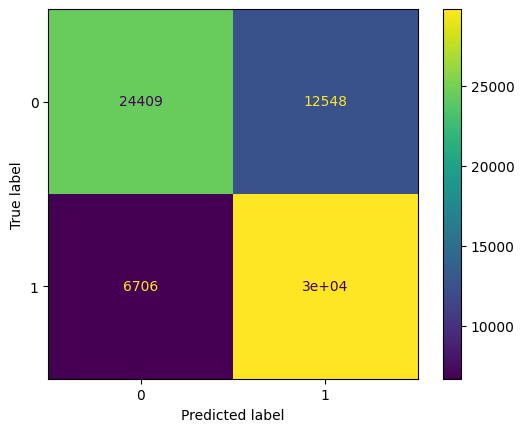

In [ ]:
test_pred = xgboost_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
test_report = classification_report(y_test, test_pred)
test_cm = confusion_matrix(y_test, test_pred)

print("\n=== Test Set Evaluation ===")
print("Test Accuracy:", test_accuracy)
print("Classification Report:\n", test_report)
print("Confusion Matrix:\n", test_cm)

ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=xgboost_model.classes_).plot()


#Detection System

In [ ]:
def detect(input_text):
    # Preprocessing and vectorizing the input text using the saved TF-IDF vectorizer
    vectorized_text = tfidf_vectorizer.transform([input_text])

    # Predicting using the trained model,ie , XGBoost
    result = xgboost_model.predict(vectorized_text)

    # Interpreting the result
    return "Plagiarism Detected" if result[0] == 1 else "No Plagiarism"


In [ ]:
input_text = 'A man riding a bike tries to cross a busy street.'
detect(input_text)

'No Plagiarism'

In [ ]:
input_text = 'The athletic woman is participating in the javelin event.'
detect(input_text)

'Plagiarism Detected'

In [ ]:
# A sample test taken from wikipedia

#Source - https://en.wikipedia.org/wiki/COVID-19

input_text = 'Coronavirus disease 2019 (COVID-19) is a contagious disease caused by the coronavirus SARS-CoV-2. In January 2020, the disease spread worldwide, resulting in the COVID-19 pandemic.'
detect(input_text)

'Plagiarism Detected'

In [ ]:
#A sample text taken from wikipedia

#Source - https://en.wikipedia.org/wiki/Finance_in_India

input_text = 'The Indian money market is classified into: the organised sector (comprising private, public and foreign owned commercial banks and cooperative banks, together known as scheduled banks); and the unorganised sector (comprising individual or family owned indigenous bankers or money lenders and non-banking financial companies (NBFCs). '
detect(input_text)

'Plagiarism Detected'

In [ ]:
#Normal text wirtten by me

input_text = 'A school is hosting a basketball game'
detect(input_text)

'No Plagiarism'